In [ ]:
#https://techrando.com/2020/01/04/time-series-forecasting-using-a-seasonal-arima-model/
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

### 1. Import Packages

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### 2. Load Data

In [2]:
furniture = pd.read_csv(r"C:\zubeda\PGA02_Zubu\Machine Learning Models\TimeSeries\Dataset\Super_Store.csv", sep=",", encoding="cp1252")
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


### 3. Data Preparation

**3.1 Dimensions of Dataset**

In [3]:
#Checking structure of the data
furniture.shape

(2121, 21)

**3.2 Statistical Summary**

In [4]:
furniture.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,5041.643564,55726.556341,349.834887,3.785007,0.173923,8.699327
std,2885.740258,32261.888225,503.179145,2.251620,0.181547,136.049246
min,1.000000,1040.000000,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,22801.000000,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,60505.000000,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,90032.000000,435.168000,5.000000,0.300000,33.726600
max,9991.000000,99301.000000,4416.174000,14.000000,0.700000,1013.127000


**3.3 Checking for missing values**

In [5]:
#summary of the data
furniture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

Checking the stock time stamp

In [6]:
furniture['Order Date'].min(), furniture['Order Date'].max()

('1/1/2017', '9/9/2017')

We remove the columns that we do not need as well as check missing values

In [7]:
cols = ['Row ID', 'Order ID', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [8]:
furniture.isnull().sum()

Order Date    0
Ship Date     0
Sales         0
dtype: int64

**3.5 Indexing with Date**

Aggregate price by date

In [9]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [10]:
furniture['Order Date'] = pd.to_datetime(furniture['Order Date'])
furniture.set_index('Order Date', inplace=True)
furniture.index

DatetimeIndex(['2017-01-01', '2014-01-10', '2015-01-10', '2016-01-10',
               '2014-01-11', '2016-01-11', '2017-01-12', '2014-01-13',
               '2015-01-13', '2017-01-13',
               ...
               '2014-09-07', '2015-09-07', '2017-09-07', '2014-09-08',
               '2015-09-08', '2016-09-08', '2017-09-08', '2014-09-09',
               '2016-09-09', '2017-09-09'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [11]:
furniture.head()

,Sales
Order Date,
2017-01-01,975.490
2014-01-10,51.940
2015-01-10,1018.104
2016-01-10,104.770
2014-01-11,9.940


### 4. Time Series Analysis

**4.1 Visualizing Data**

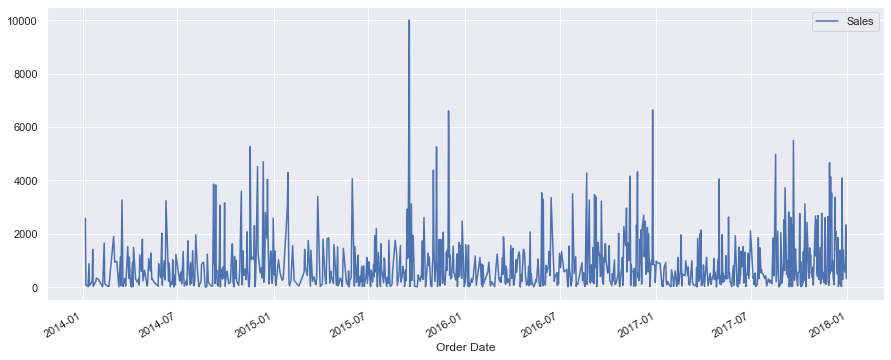

In [12]:
furniture.plot(figsize=(15, 6))
plt.show()

**4.2 Sampling**

In [13]:
y = furniture['Sales'].resample('MS').mean()  #Month Start Resampling
y

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049187
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412013
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

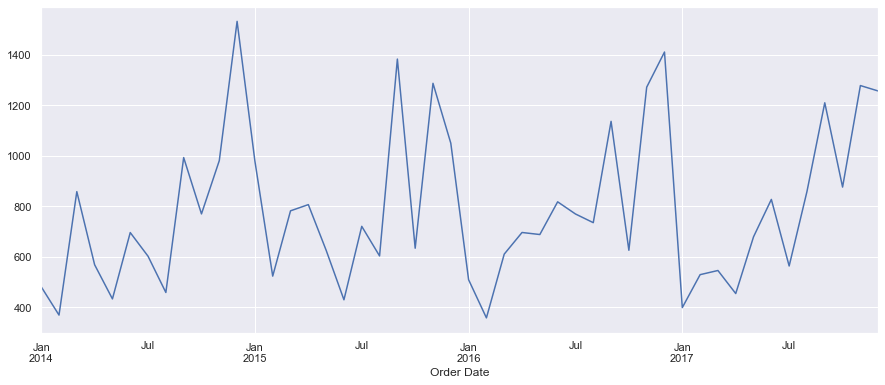

In [14]:
y.plot(figsize=(15, 6))
plt.show()

**4.3 Checking Stationarity**

In [15]:
from statsmodels.tsa.stattools import adfuller
from pandas import Series

result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' %(key, value))

ADF Statistic: -5.191070
p-value: 0.000009
Critical Values: 
	1%: -3.621
	5%: -2.944
	10%: -2.610


**4.4 Decomposing**

Decomposing the time series into 3 distinct components

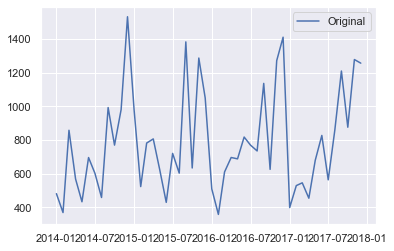

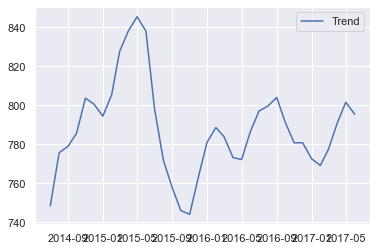

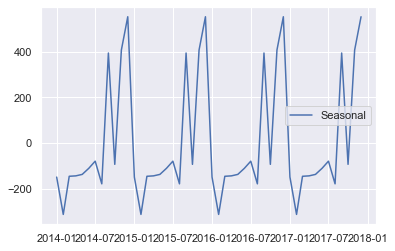

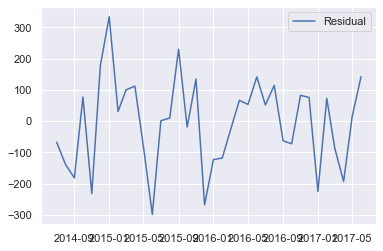

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y)

plt.plot(y, label='Original')
plt.legend(loc='best')

trend = decomposition.trend
plt.show()
plt.plot(trend, label='Trend')
plt.legend(loc='best')

seasonal = decomposition.seasonal
plt.show()
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

residual = decomposition.resid
plt.show()
plt.plot(residual, label='Residual')
plt.legend(loc='best')

### 5. Time Series Forecasting using ARIMA

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#The m parameter influences the p, d, and q parameters. For example, an m of 12 for monthly data
#suggests a yearly seasonal cycle.
print('Examples for parameter combination for Seasonal ARIMA....')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples for parameter combination for Seasonal ARIMA....
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


**5.1 Parameter Selection**

We use 'grid search' to find the optimal set of parameters that yields the best performance for our model

In [18]:
#The SARIMA time series forecasting method is supported in Python via the Statsmodels library
#An instance of the SARIMAX class can be created by providing the training data and a host of model
#configuration parameters.
#The implementation is called SARIMAX instead of SARIMA because the “X” addition to the method name
#means that the implementation also supports exogenous variables.
#Exogenous variables are variables whose cause is external to the model and whose role is to explain
#other variables or outcomes in the model.
#exogenous variables: external params affecting the model
from pylab import rcParams
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
#enforce_stationarity - Whether or not to transform the AR parameters to enforce stationarity in the
#autoregressive component of the model. Default is True.
#enforce_invertibility - Whether or not to transform the MA parameters to enforce invertibility in the 
#moving average component of the model. Default is True.
#Invertibility refers to linear stationary process which behaves like infinite representation of
#autoregressive. In other word, this is the property that possessed by a moving average process.
#Invertibility solves non-uniqueness of autocorrelation function of moving average.
#The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative
#quality of statistical models for a given set of data. Given a collection of models for the data,
#AIC estimates the quality of each model, relative to each of the other models.

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1333.9771751228404
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920111
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793744
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1466.9694020729205
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803026765
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758114


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2616.337077775353
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809133
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673305

C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.6054906545426
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2379.9538910982315
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468674
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576489975
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1244.0928031338074
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672282035
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.96712281679595
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663004408


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1238.2168117811916
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.91132001514677
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817154


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1440.128487445248
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482981
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.58062333806373
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442638


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2138.999077212543
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.75743684172994
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.55766214612356
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067713


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1492.1848519861862
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.20776751609566
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935204


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1145.3792510056328
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084567
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921438627
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442186183


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:605.5705470612959
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.36851958170354
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.3422193965913
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323877007


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2390.198853052243
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.01560021187225
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.7513188209053
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541903
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1360.3596504510133
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.20034222811347
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.2130611619098
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658784693


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1029.0883997963615
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.62709013454315
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.3264992510779
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835615
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2416.6417547407355
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.476268760984
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.38730069393927
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.52503546607727


C:\Users\ashraf\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:186.51207602001722
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.78754395312376
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.36610143644174


**5.2 Fitting the ARIMA model**

In [19]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

#The model summary above contains the ‘Covariance Type’ graph, which depicts each of the variables’
#impact on the forecast. We have four main lagged AR and MA variables. The first set of AR and MA
#variables is lagged by 1 time step (ar.L1 and ma.L1, respectively), and the second set is lagged by
#12 time steps (ar.S.L12 and ma.S.L12).

#Looking at the ‘P>abs(z)’ term in the graph, all variables read as 0. This is great, as we want our P
#values to be as close to 0 as possible. Using a cutoff of <0.05 for statistical significance, all of
#our lagged AR and MA terms significantly impact model forecast.

#The sigma2 output in the coefficients table is the estimate of the variance of the error term

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0949      0.313     -0.303      0.762      -0.708       0.518
ma.L1         -1.0000      0.415     -2.409      0.016      -1.814      -0.186
ar.S.L12      -0.0036      0.424     -0.008      0.993      -0.834       0.827
ma.S.L12      -0.3011      0.501     -0.601      0.548      -1.283       0.681
sigma2      2.476e+04   1.68e-05   1.48e+09      0.000    2.48e+04    2.48e+04


**5.3 Validating Forecasts**

We compare predicted sales to real sales of the time series to understand the accuracy of our forecasts

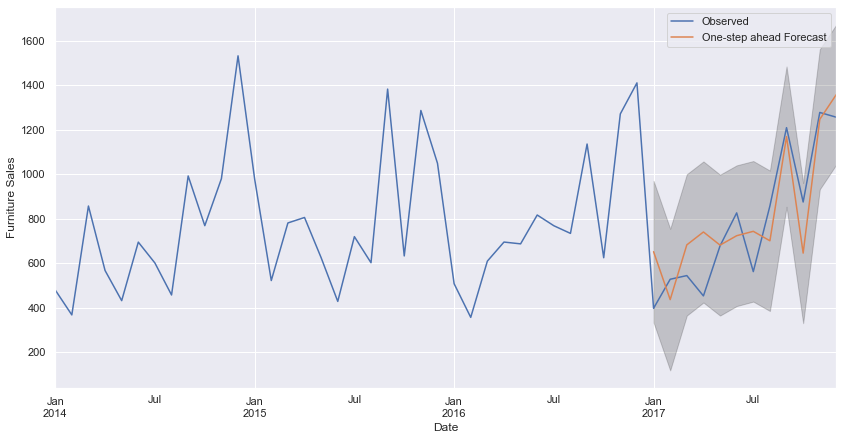

In [20]:
#set forecasts to start at 2017-01-01 to the end of the data to forecast
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
#conf_int: Returns the confidence interval of the filled parameters
ax = y['2014':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=1, figsize=(14, 7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()
#Matplotlib allows you to adjust the transparency of a graph plot using the alpha attribute. 
#By default, alpha=1. If you want to make the graph plot more transparent, then you can make alpha 
#less than 1, such as 0.5 or 0.25. If you want to make the graph plot less transparent, then you can 
#make alpha greater than 1.

**5.4 Calculating MSE and RMSE**

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean squared Error of our forecasts is 25708.53
The Root Mean squared Error of our forecasts is 160.34


**5.5 Visulaizing the Forecast**

            lower Sales  upper Sales
2018-01-01   180.620653   809.063616
2018-02-01   186.313018   815.743756
2018-03-01   282.723147   912.318961
2018-04-01   231.731293   861.314037
2018-05-01   371.222123  1000.806514
2018-06-01   495.556701  1125.141467
2018-07-01   318.524945   948.110350
2018-08-01   505.351470  1134.937634
2018-09-01   900.318104  1529.905158
2018-10-01   503.964138  1133.552216
2018-11-01   970.180217  1599.769434
2018-12-01   983.032779  1612.623731
2019-01-01   113.362506   891.789632


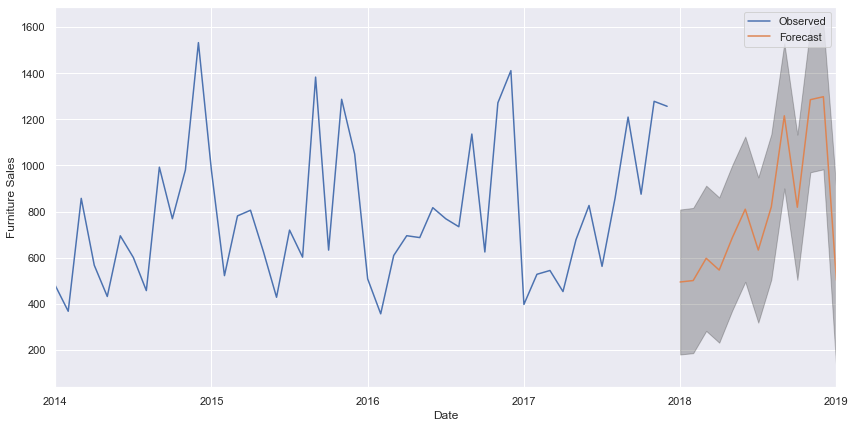

In [22]:
pred_uc = results.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
print(pred_ci)
plt.legend()
plt.show()

In [23]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1080x864 with 0 Axes>

### Conclusion

We observe that sales of furniture produces seasonal pattern. Early of the year is the off season for furniture sales in the superstore. The sales for furniture increases linearly over time.